# 1.16b: Acceleration Profiles - The S-Curve Hypothesis

**Goal:** Test Jeffery's rocket equation hypothesis—do tokens show S-curve acceleration profiles?

## The Hypothesis

Tokens under **constant thrust with varying effective mass** should show:

1. **Shallow start:** Low Adam momentum → small updates → low acceleration
2. **Steep middle:** Momentum accumulating → accelerating acceleration (like a rocket as fuel burns)
3. **Shallow end:** Gradients decay or momentum saturates → acceleration plateaus

This would explain:
- Why paths wander (efficiency = 80%)
- Why motion is mostly tangential (not pure radial explosion)
- Why kicks are distributed throughout training (not one initial impulse)

## What We'll Plot

- **Individual token acceleration curves** (all 30,590 trained tokens, low alpha overlay)
- **Aggregate statistics** (mean/median/percentiles to see overall shape)
- **Example S-curves** (tokens that clearly show the pattern)
- **Adam momentum correlation** (if data available)

If the hypothesis is correct, we should see:
- A "cloud" of overlapping S-curves
- Mean acceleration curve showing sigmoid-like shape
- Strong correlation between momentum magnitude and acceleration

## Parameters

In [1]:
# Training data
TRAINING_DATA_PATH = "../tensors/Wordybird/1.12c_wordybird_1.safetensors"
TOKEN_MASK_PATH = "../tensors/Wordybird/fineweb_token_masks.safetensors"

# Visualization
PLOT_DPI = 200
ALPHA = 0.01  # Very transparent for overlaying 30k curves
N_EXAMPLE_TOKENS = 10  # Number of example S-curves to highlight

## Imports

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from safetensors.torch import load_file
from scipy.signal import savgol_filter

print("✓ Imports complete")

✓ Imports complete


## Load Data

In [3]:
print("Loading training data...\n")

# Training data
data = load_file(TRAINING_DATA_PATH)
embeddings = data['embeddings'].float()  # (n_steps, vocab_size, hidden_dim)
n_steps, vocab_size, hidden_dim = embeddings.shape

# Check if momentum data is available
has_momentum = 'momentum' in data
if has_momentum:
    momentum = data['momentum'].float()  # (n_steps, vocab_size, hidden_dim)
    print("✓ Momentum data available")
else:
    print("⚠️  No momentum data in file")

# Token masks
mask_data = load_file(TOKEN_MASK_PATH)
trained_indices = mask_data['trained_indices']
untrained_indices = mask_data['untrained_indices']

n_trained = len(trained_indices)
n_untrained = len(untrained_indices)

print(f"\n✓ Loaded data")
print(f"  Steps: {n_steps}")
print(f"  Vocab: {vocab_size} ({n_trained} trained, {n_untrained} untrained)")
print(f"  Hidden dim: {hidden_dim}")

Loading training data...

✓ Momentum data available

✓ Loaded data
  Steps: 101
  Vocab: 50257 (30590 trained, 19667 untrained)
  Hidden dim: 64


## Compute Kinematics for Trained Tokens

In [4]:
print("\nComputing kinematics...\n")

# Extract trained token trajectories
trained_traj = embeddings[:, trained_indices, :]  # (n_steps, n_trained, hidden_dim)

# Velocity (displacement per step)
deltas = trained_traj[1:] - trained_traj[:-1]  # (n_steps-1, n_trained, hidden_dim)
speeds = torch.norm(deltas, p=2, dim=2)  # (n_steps-1, n_trained)

# Acceleration (change in speed)
accelerations = speeds[1:] - speeds[:-1]  # (n_steps-2, n_trained)

print(f"✓ Computed kinematics")
print(f"  Speeds: {speeds.shape}")
print(f"  Accelerations: {accelerations.shape}")

# If momentum data available, compute momentum magnitude for trained tokens
if has_momentum:
    trained_momentum = momentum[:, trained_indices, :]  # (n_steps, n_trained, hidden_dim)
    momentum_magnitudes = torch.norm(trained_momentum, p=2, dim=2)  # (n_steps, n_trained)
    print(f"  Momentum magnitudes: {momentum_magnitudes.shape}")


Computing kinematics...

✓ Computed kinematics
  Speeds: torch.Size([100, 30590])
  Accelerations: torch.Size([99, 30590])
  Momentum magnitudes: torch.Size([101, 30590])


## Aggregate Statistics

In [5]:
print("\nComputing aggregate statistics...\n")

# Mean and percentiles across all tokens
accel_mean = accelerations.mean(dim=1).numpy()  # (n_steps-2,)
accel_median = accelerations.median(dim=1).values.numpy()
accel_p25 = accelerations.quantile(0.25, dim=1).numpy()
accel_p75 = accelerations.quantile(0.75, dim=1).numpy()

timesteps = np.arange(len(accel_mean)) + 1  # Acceleration at t means change from t to t+1

print(f"✓ Statistics computed")
print(f"  Mean acceleration range: [{accel_mean.min():.6e}, {accel_mean.max():.6e}]")
print(f"  Peak mean acceleration at step: {timesteps[accel_mean.argmax()]}")


Computing aggregate statistics...

✓ Statistics computed
  Mean acceleration range: [-1.607753e-03, 4.101892e-05]
  Peak mean acceleration at step: 4


## Identify Example S-Curve Tokens

Find tokens that show clear S-curve pattern:
1. Low acceleration early
2. Peak acceleration in middle
3. Lower acceleration late

In [6]:
print("\nIdentifying S-curve example tokens...\n")

# For each token, compute:
# - Early acceleration (mean of first third)
# - Mid acceleration (mean of middle third)
# - Late acceleration (mean of last third)

n_accel = accelerations.shape[0]
third = n_accel // 3

early_accel = accelerations[:third].mean(dim=0)  # (n_trained,)
mid_accel = accelerations[third:2*third].mean(dim=0)
late_accel = accelerations[2*third:].mean(dim=0)

# S-curve score: mid should be higher than both early and late
s_curve_score = (mid_accel - early_accel) + (mid_accel - late_accel)

# Find top S-curve tokens
top_s_indices = torch.argsort(s_curve_score, descending=True)[:N_EXAMPLE_TOKENS]
top_s_token_ids = trained_indices[top_s_indices].tolist()

print(f"✓ Identified {N_EXAMPLE_TOKENS} tokens with strongest S-curve pattern")
print(f"  Token IDs: {top_s_token_ids[:5]}...")
print(f"  S-curve scores: {s_curve_score[top_s_indices[:3]].tolist()}")


Identifying S-curve example tokens...

✓ Identified 10 tokens with strongest S-curve pattern
  Token IDs: [30271, 6350, 4202, 4836, 31172]...
  S-curve scores: [0.0003930317470803857, 0.00039237336022779346, 0.00039216759614646435]


## Visualization: Acceleration Cloud (All Tokens)


Plotting acceleration cloud...



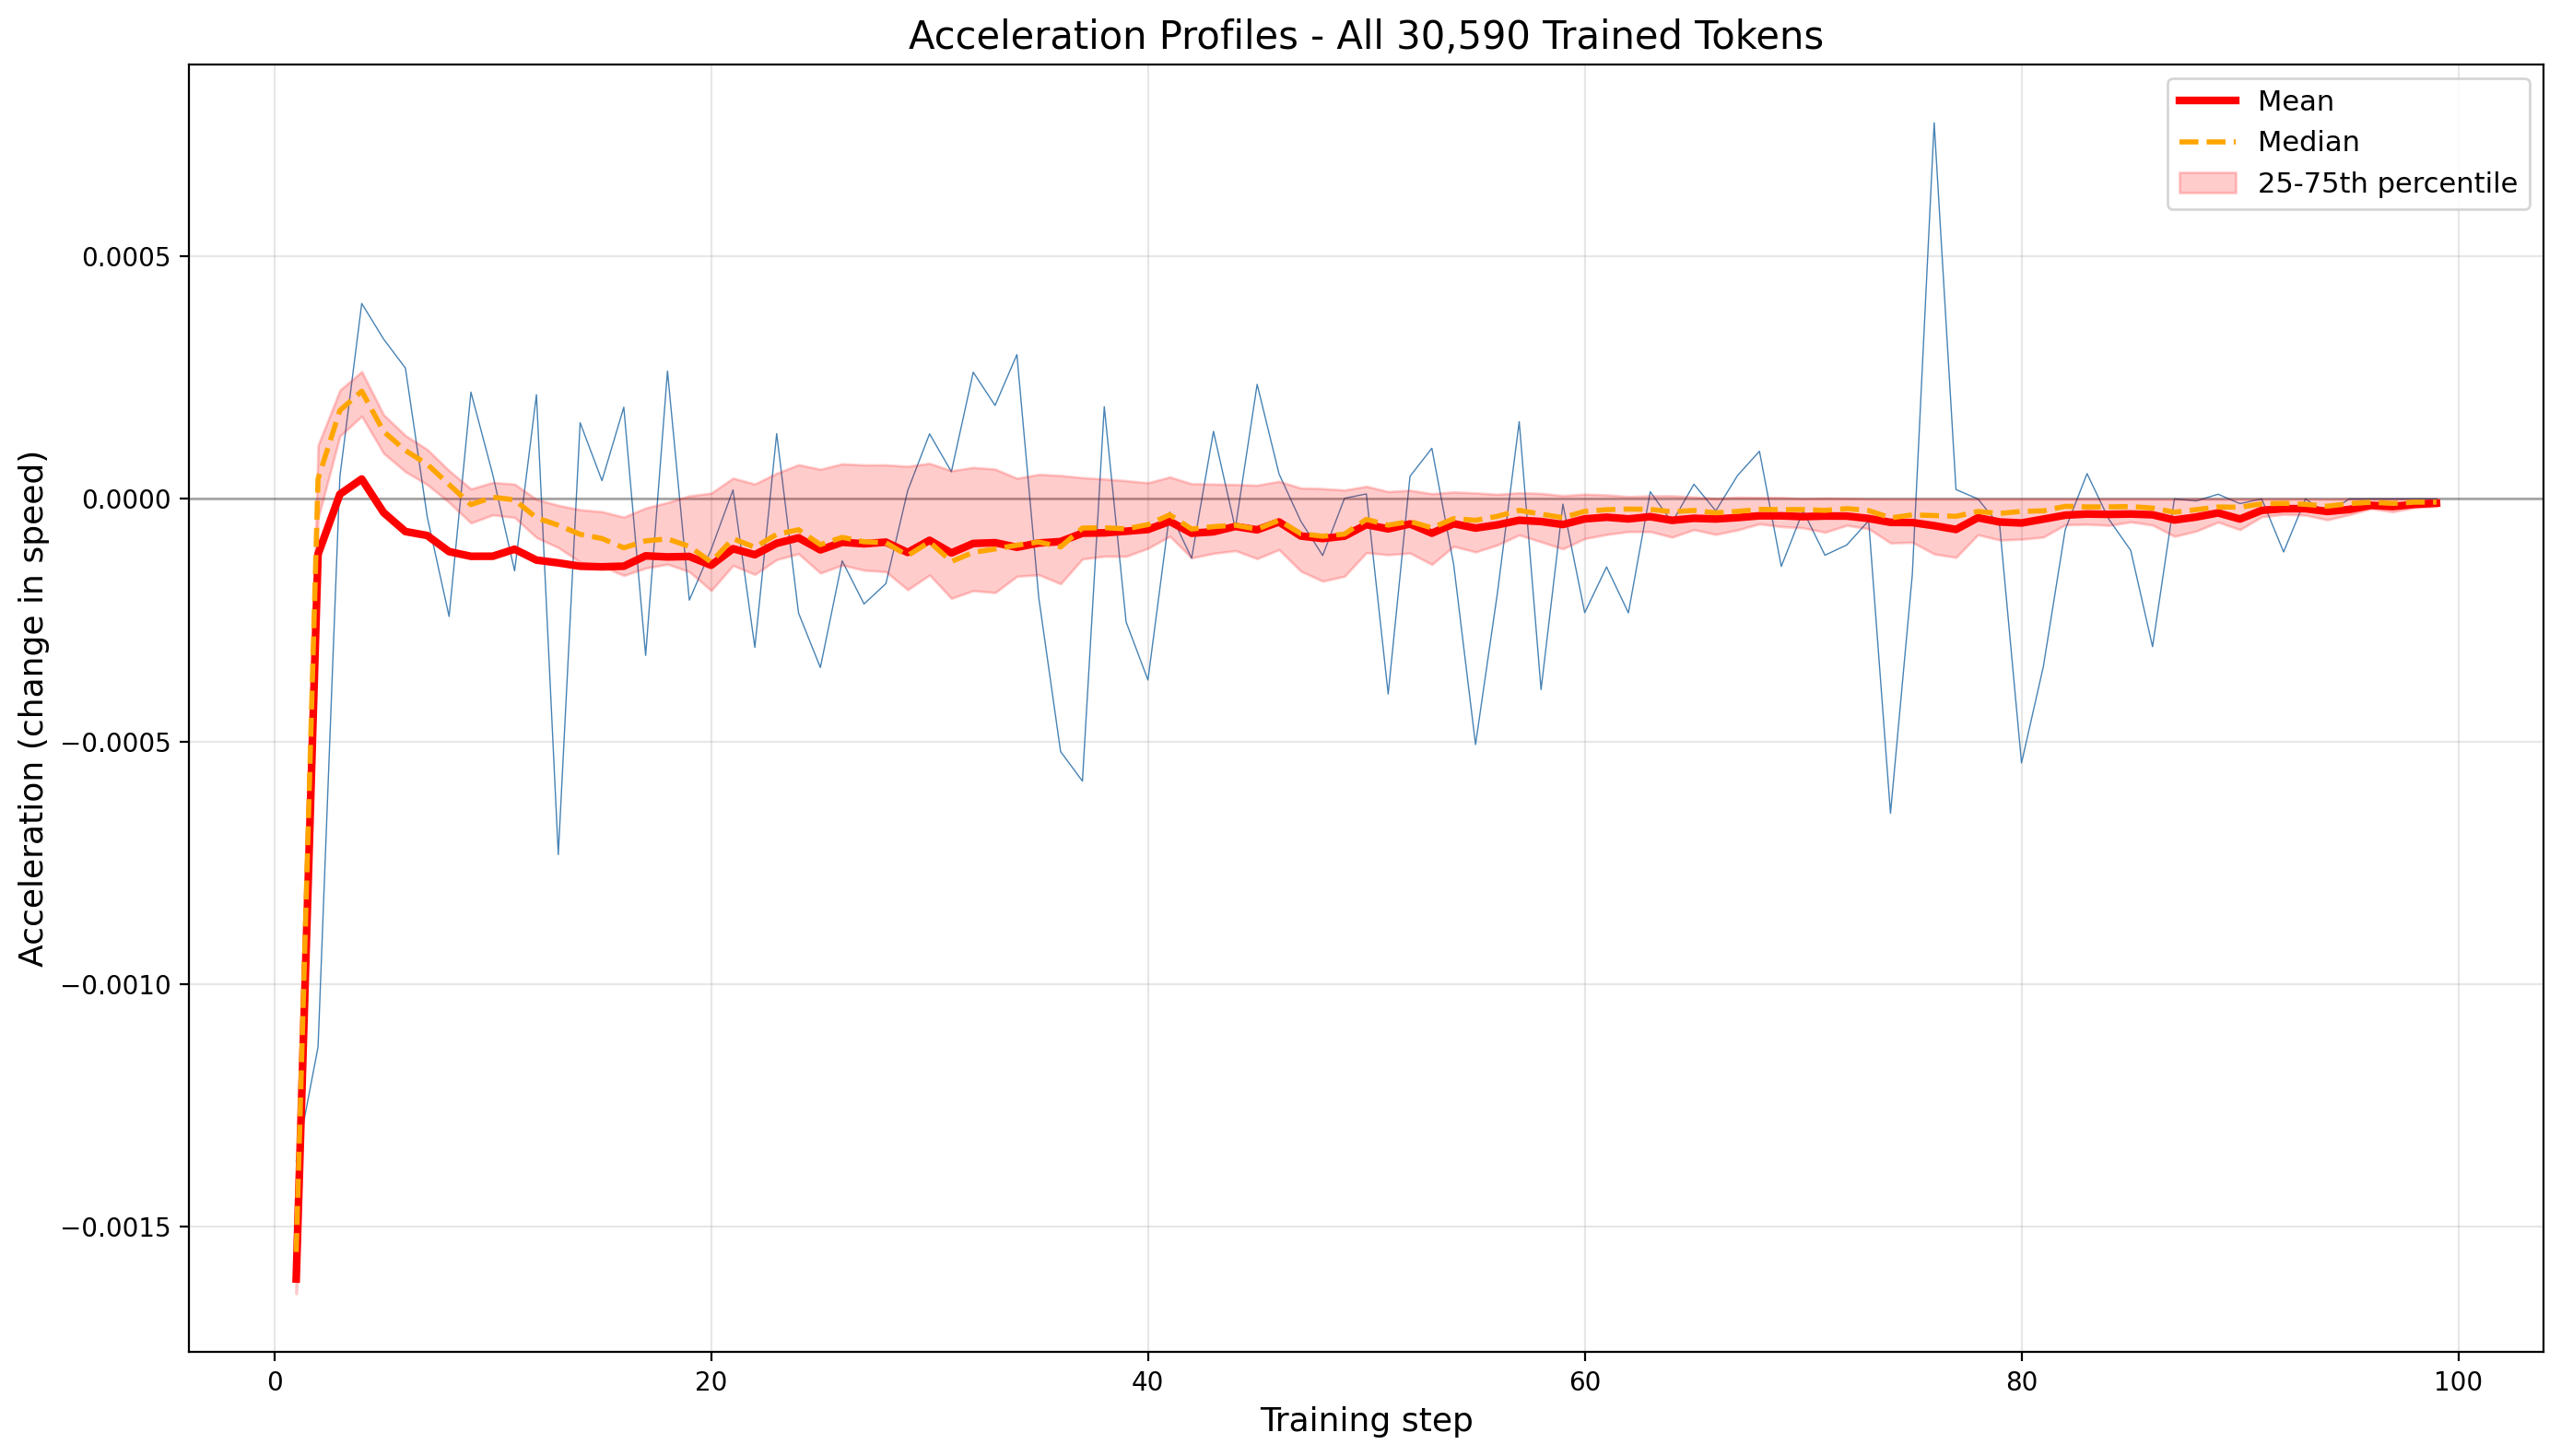

✓ Cloud plot complete


In [17]:
print("\nPlotting acceleration cloud...\n")

fig, ax = plt.subplots(figsize=(14, 8), dpi=PLOT_DPI)

# Plot all individual token acceleration curves (very transparent)
# for i in range(n_trained):
for i in [0]:
    ax.plot(timesteps, accelerations[:, i].numpy(), 
            color='steelblue', alpha=1, linewidth=0.5)

# Overlay aggregate statistics
ax.plot(timesteps, accel_mean, color='red', linewidth=3, label='Mean', zorder=10)
ax.plot(timesteps, accel_median, color='orange', linewidth=2, linestyle='--', label='Median', zorder=10)
ax.fill_between(timesteps, accel_p25, accel_p75, color='red', alpha=0.2, label='25-75th percentile', zorder=5)

# Zero line
ax.axhline(0, color='black', linewidth=1, linestyle='-', alpha=0.3)

ax.set_xlabel('Training step', fontsize=13)
ax.set_ylabel('Acceleration (change in speed)', fontsize=13)
ax.set_title(f'Acceleration Profiles - All {n_trained:,} Trained Tokens', fontsize=15)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Cloud plot complete")

## Visualization: Example S-Curves


Plotting example S-curves...



/var/folders/k5/44vd1ct56xj4y9h7x213kvjr0000gn/T/ipykernel_36040/101525727.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('viridis', N_EXAMPLE_TOKENS)


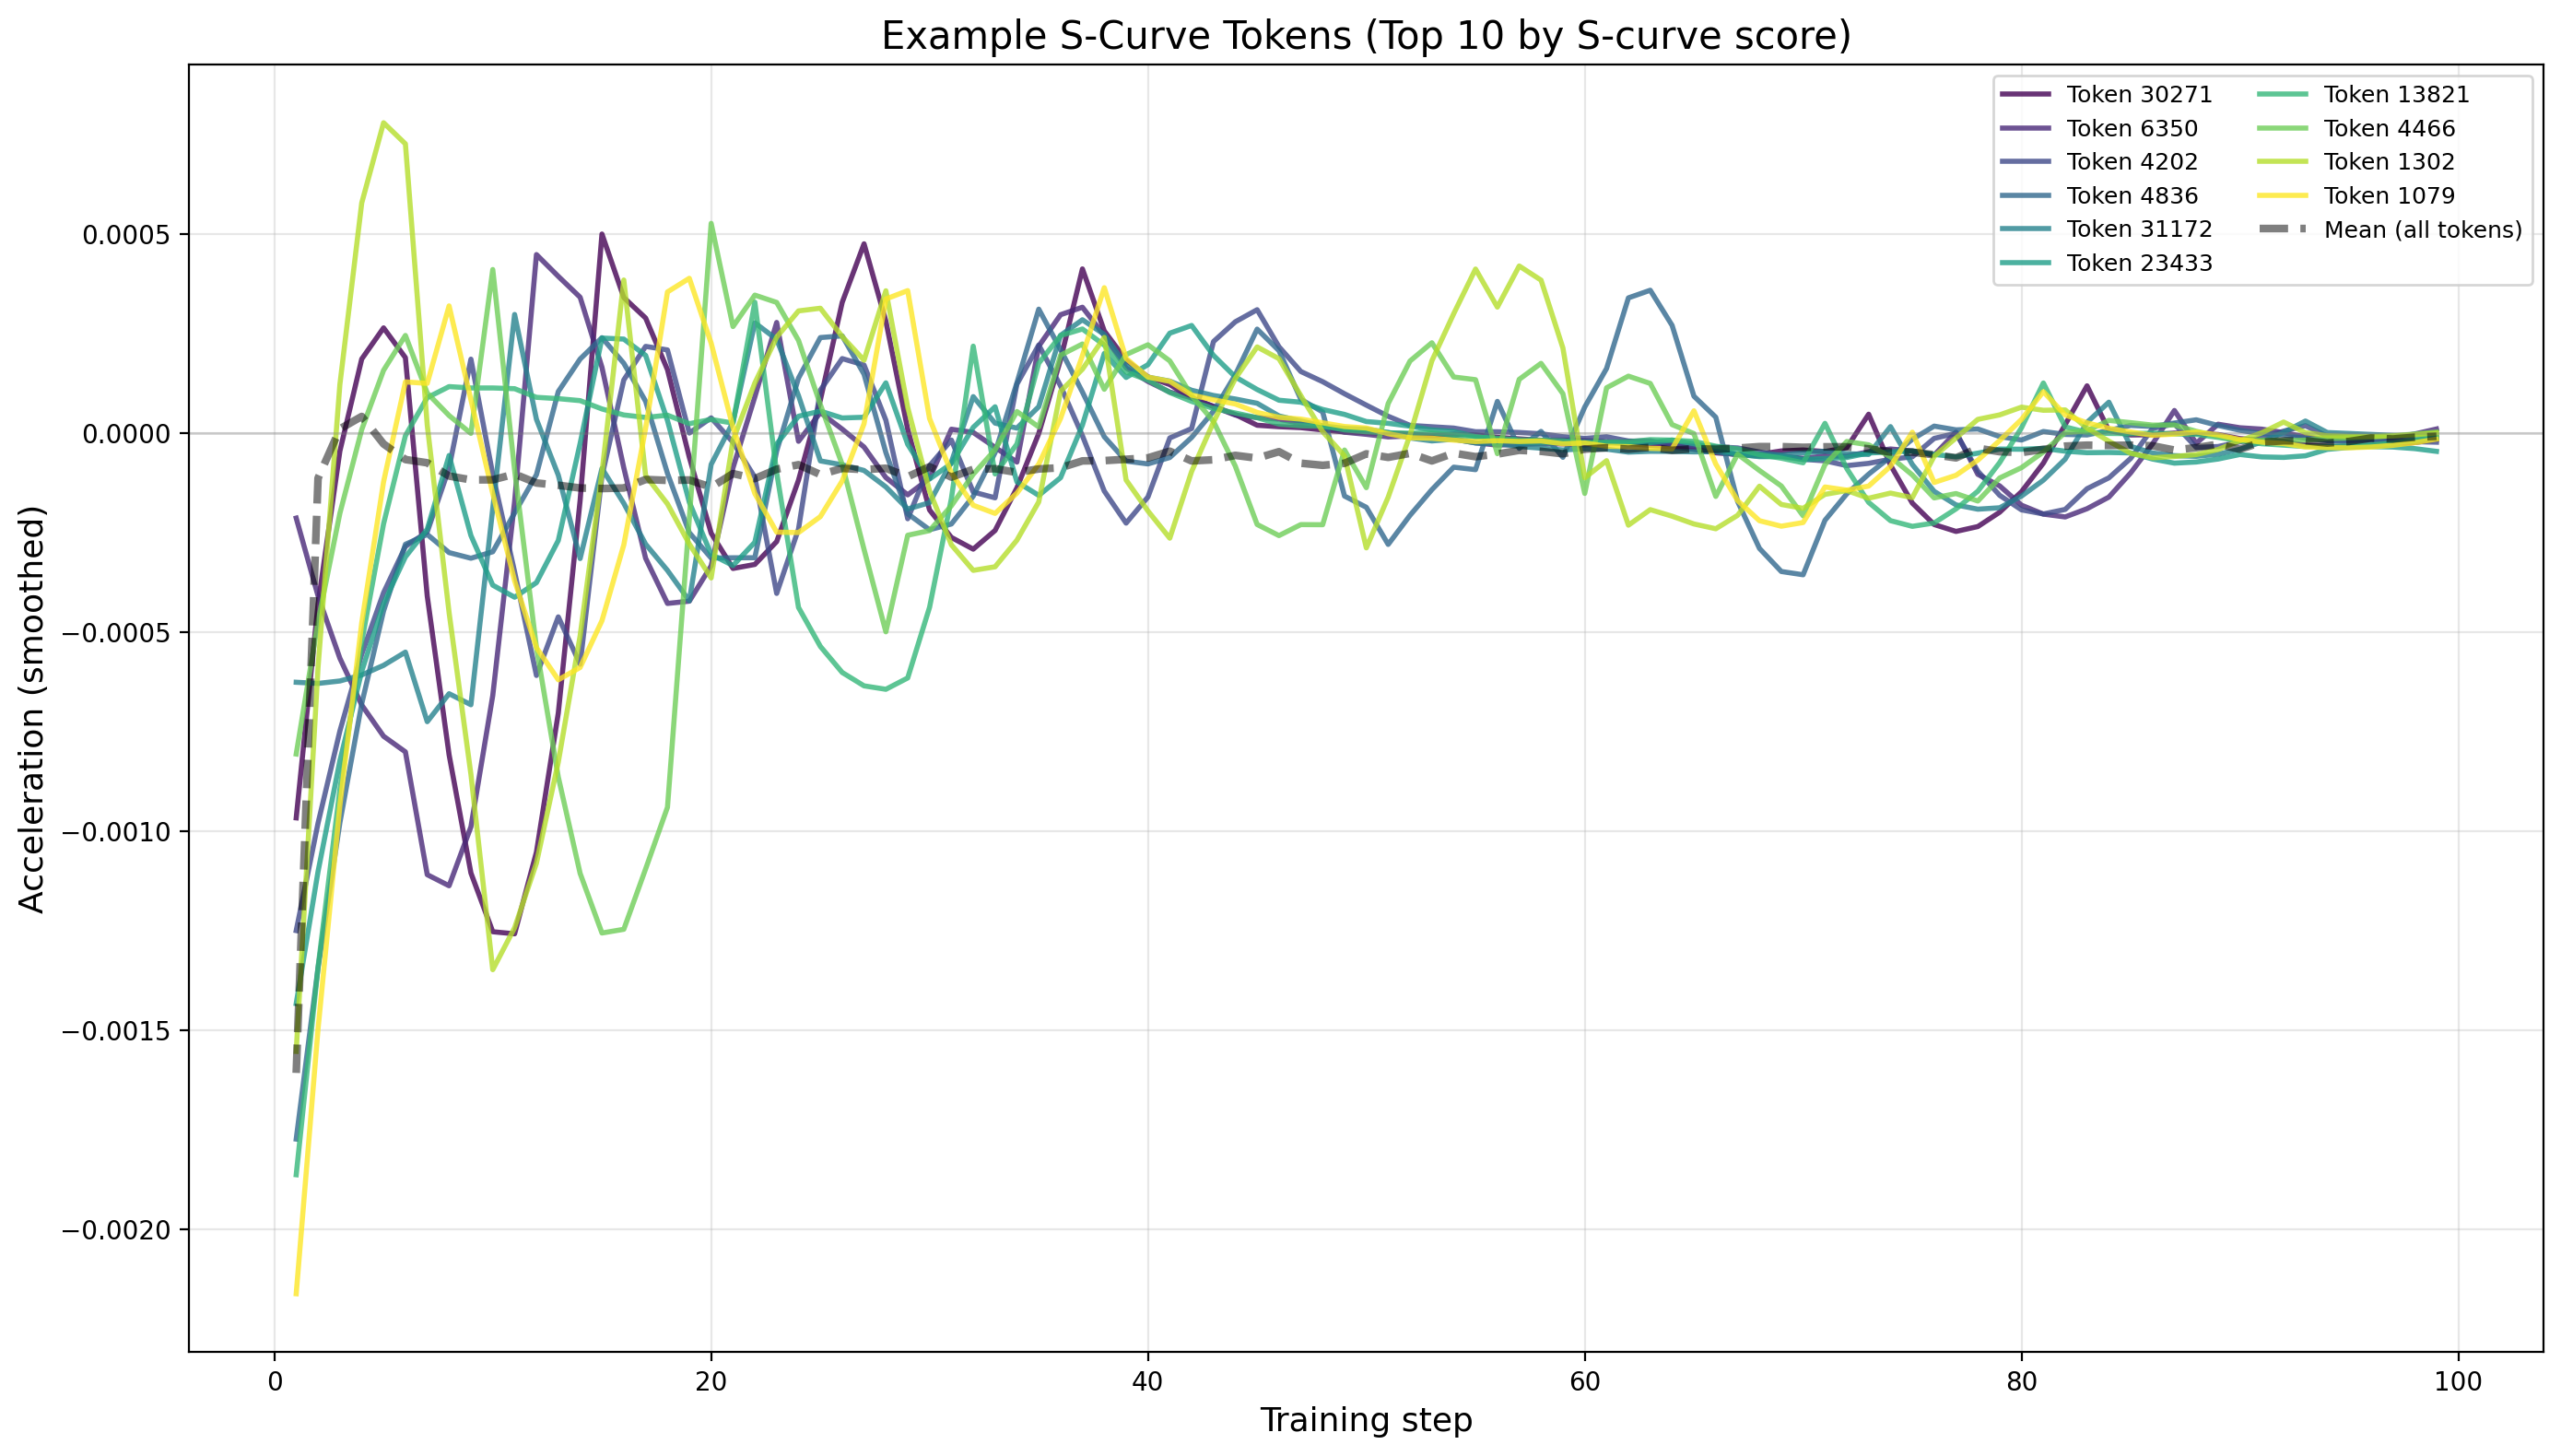

✓ Example S-curves plotted


In [18]:
print("\nPlotting example S-curves...\n")

fig, ax = plt.subplots(figsize=(14, 8), dpi=PLOT_DPI)

# Plot selected S-curve examples
cmap = plt.cm.get_cmap('viridis', N_EXAMPLE_TOKENS)

for idx, token_global_idx in enumerate(top_s_indices[:N_EXAMPLE_TOKENS]):
    token_id = trained_indices[token_global_idx].item()
    accel_curve = accelerations[:, token_global_idx].numpy()
    
    # Smooth for visibility (Savitzky-Golay filter)
    if len(accel_curve) > 10:
        accel_smooth = savgol_filter(accel_curve, window_length=min(11, len(accel_curve)//2*2+1), polyorder=2)
    else:
        accel_smooth = accel_curve
    
    ax.plot(timesteps, accel_smooth, color=cmap(idx), linewidth=2, 
            label=f'Token {token_id}', alpha=0.8)

# Mean curve for reference
ax.plot(timesteps, accel_mean, color='black', linewidth=3, 
        linestyle='--', label='Mean (all tokens)', alpha=0.5, zorder=5)

# Zero line
ax.axhline(0, color='gray', linewidth=1, linestyle='-', alpha=0.3)

ax.set_xlabel('Training step', fontsize=13)
ax.set_ylabel('Acceleration (smoothed)', fontsize=13)
ax.set_title(f'Example S-Curve Tokens (Top {N_EXAMPLE_TOKENS} by S-curve score)', fontsize=15)
ax.legend(fontsize=9, ncol=2)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Example S-curves plotted")

## Visualization: Speed Profiles (Integral of Acceleration)

If acceleration shows an S-curve, speed (integral of acceleration) should show exponential-like growth then plateau.


Plotting speed profiles...



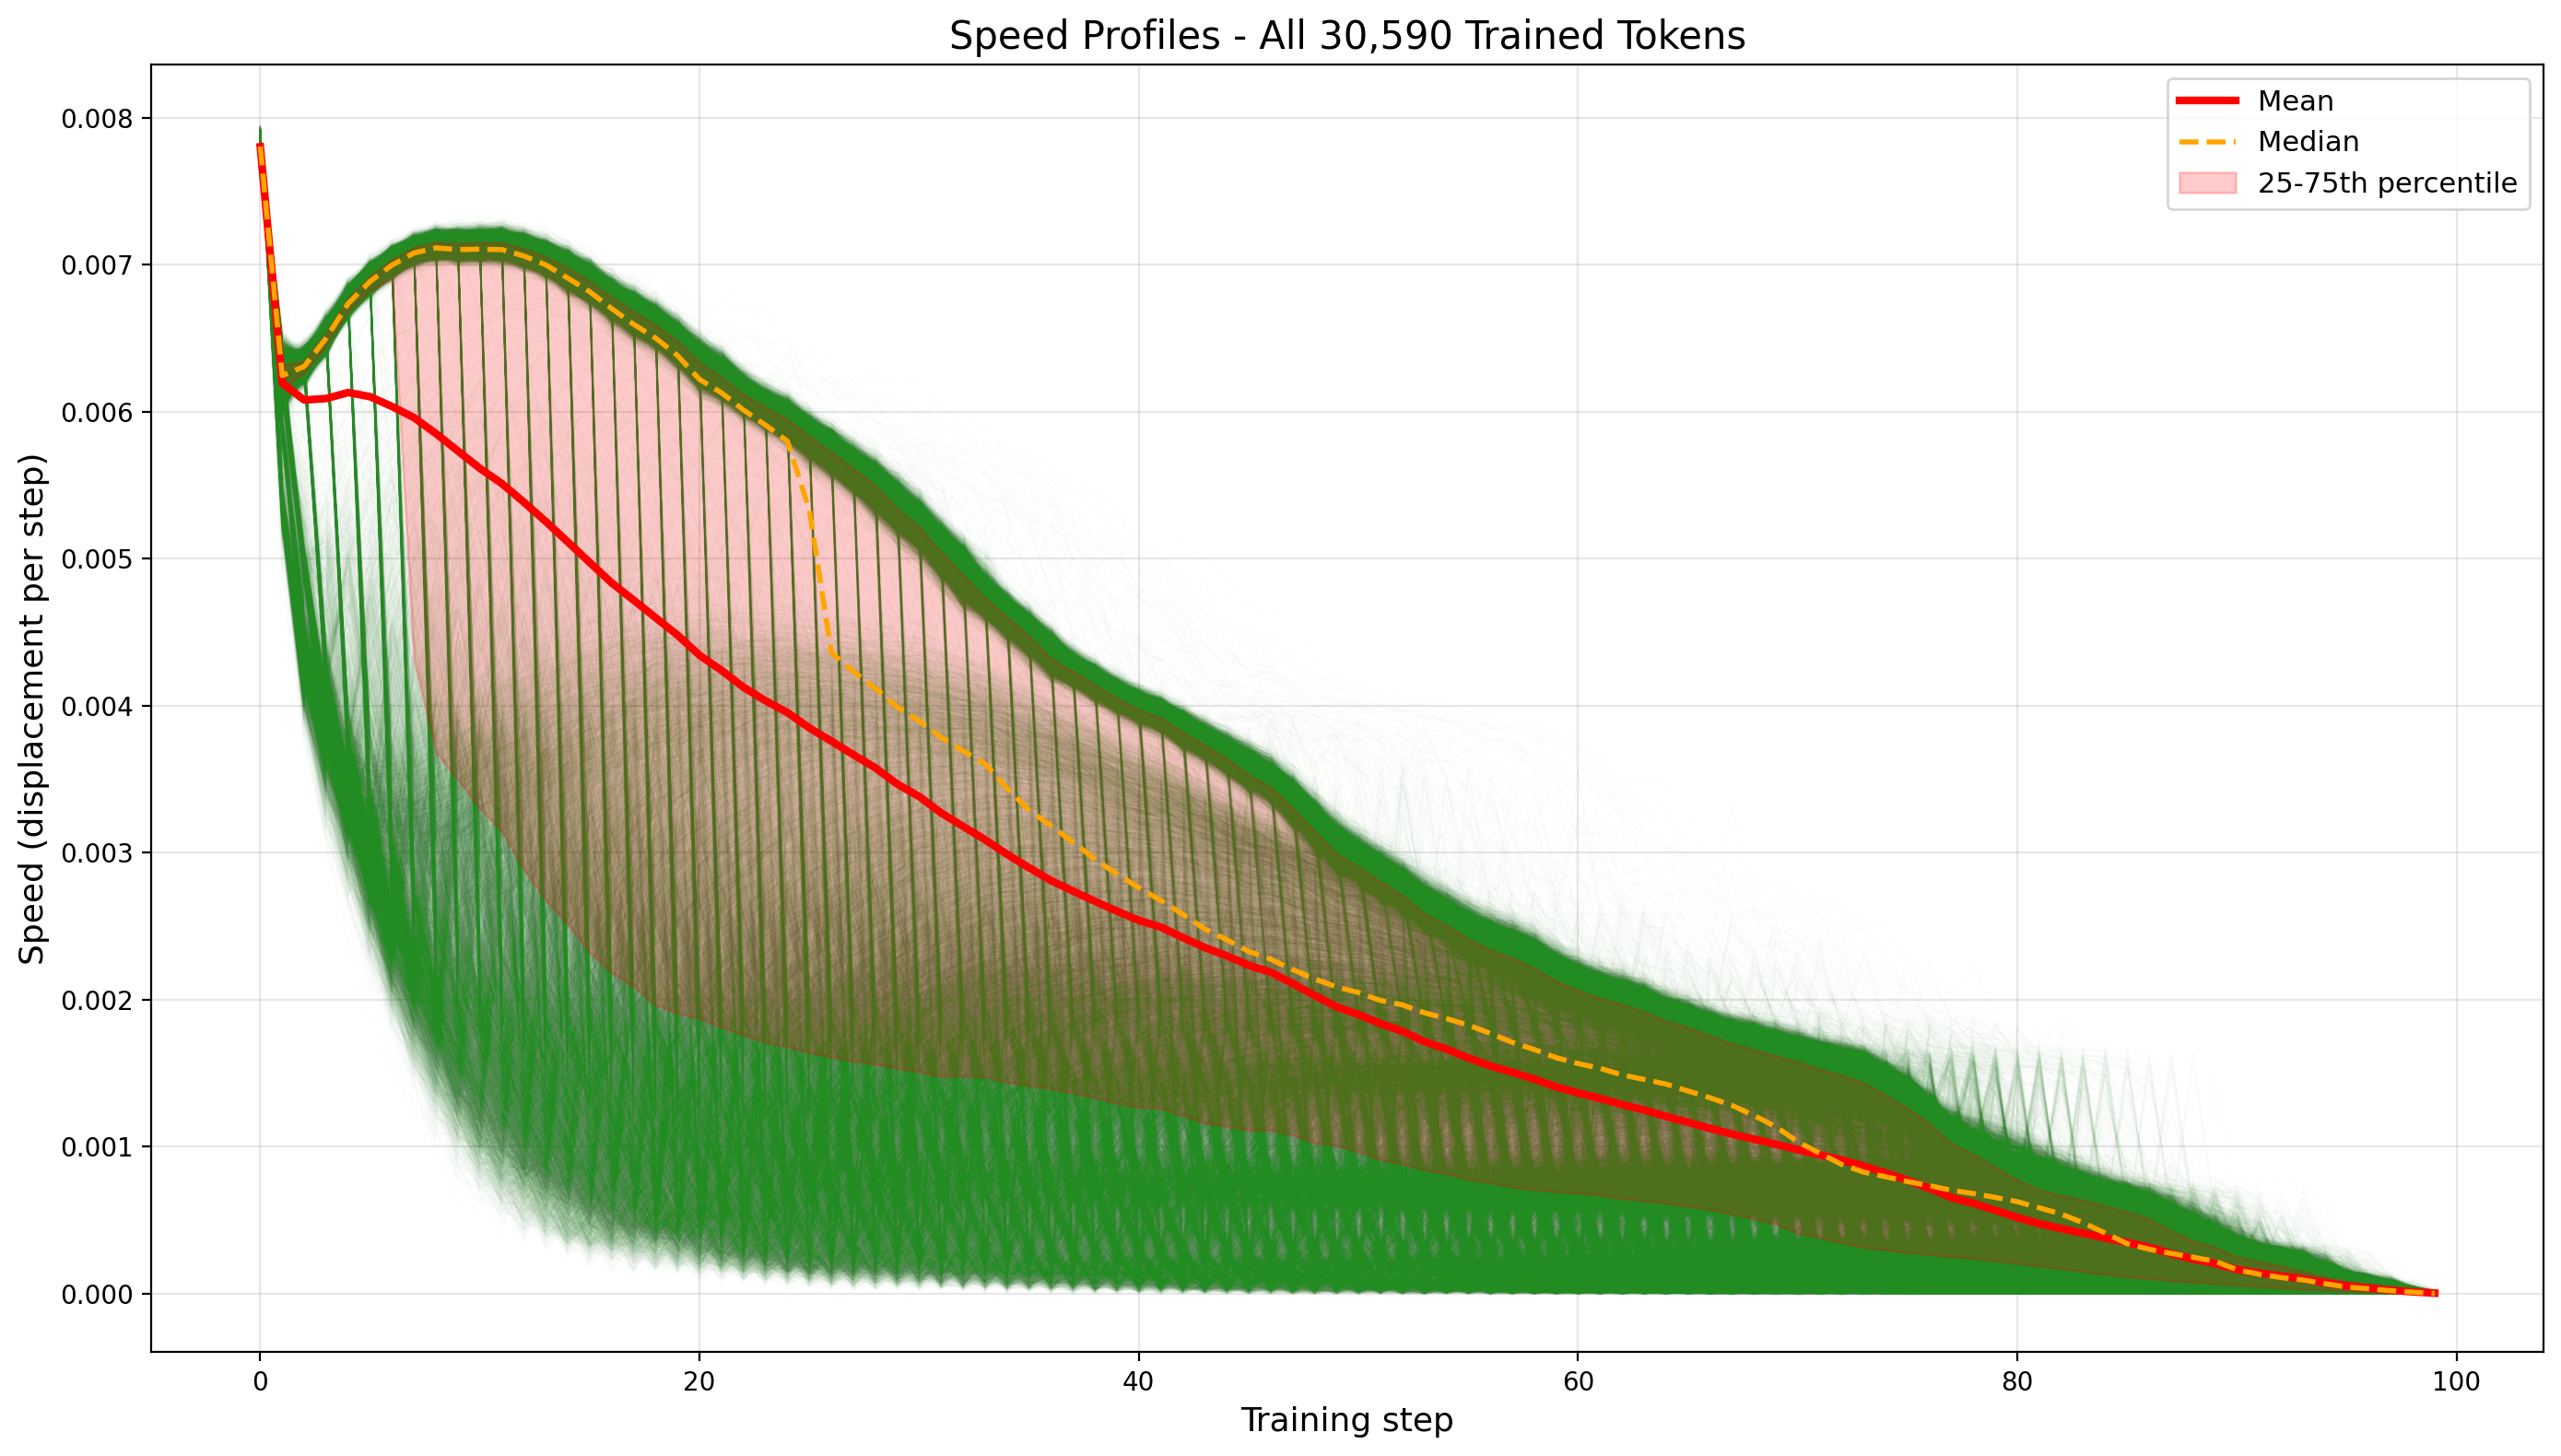

✓ Speed profiles plotted


In [19]:
print("\nPlotting speed profiles...\n")

fig, ax = plt.subplots(figsize=(14, 8), dpi=PLOT_DPI)

# Plot all token speed curves (transparent)
speed_timesteps = np.arange(speeds.shape[0])
for i in range(n_trained):
    ax.plot(speed_timesteps, speeds[:, i].numpy(), 
            color='forestgreen', alpha=ALPHA, linewidth=0.5)

# Mean speed
speed_mean = speeds.mean(dim=1).numpy()
speed_median = speeds.median(dim=1).values.numpy()
speed_p25 = speeds.quantile(0.25, dim=1).numpy()
speed_p75 = speeds.quantile(0.75, dim=1).numpy()

ax.plot(speed_timesteps, speed_mean, color='red', linewidth=3, label='Mean', zorder=10)
ax.plot(speed_timesteps, speed_median, color='orange', linewidth=2, linestyle='--', label='Median', zorder=10)
ax.fill_between(speed_timesteps, speed_p25, speed_p75, color='red', alpha=0.2, label='25-75th percentile', zorder=5)

ax.set_xlabel('Training step', fontsize=13)
ax.set_ylabel('Speed (displacement per step)', fontsize=13)
ax.set_title(f'Speed Profiles - All {n_trained:,} Trained Tokens', fontsize=15)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"✓ Speed profiles plotted")

## Adam Momentum Correlation (if available)


Analyzing momentum vs acceleration correlation...



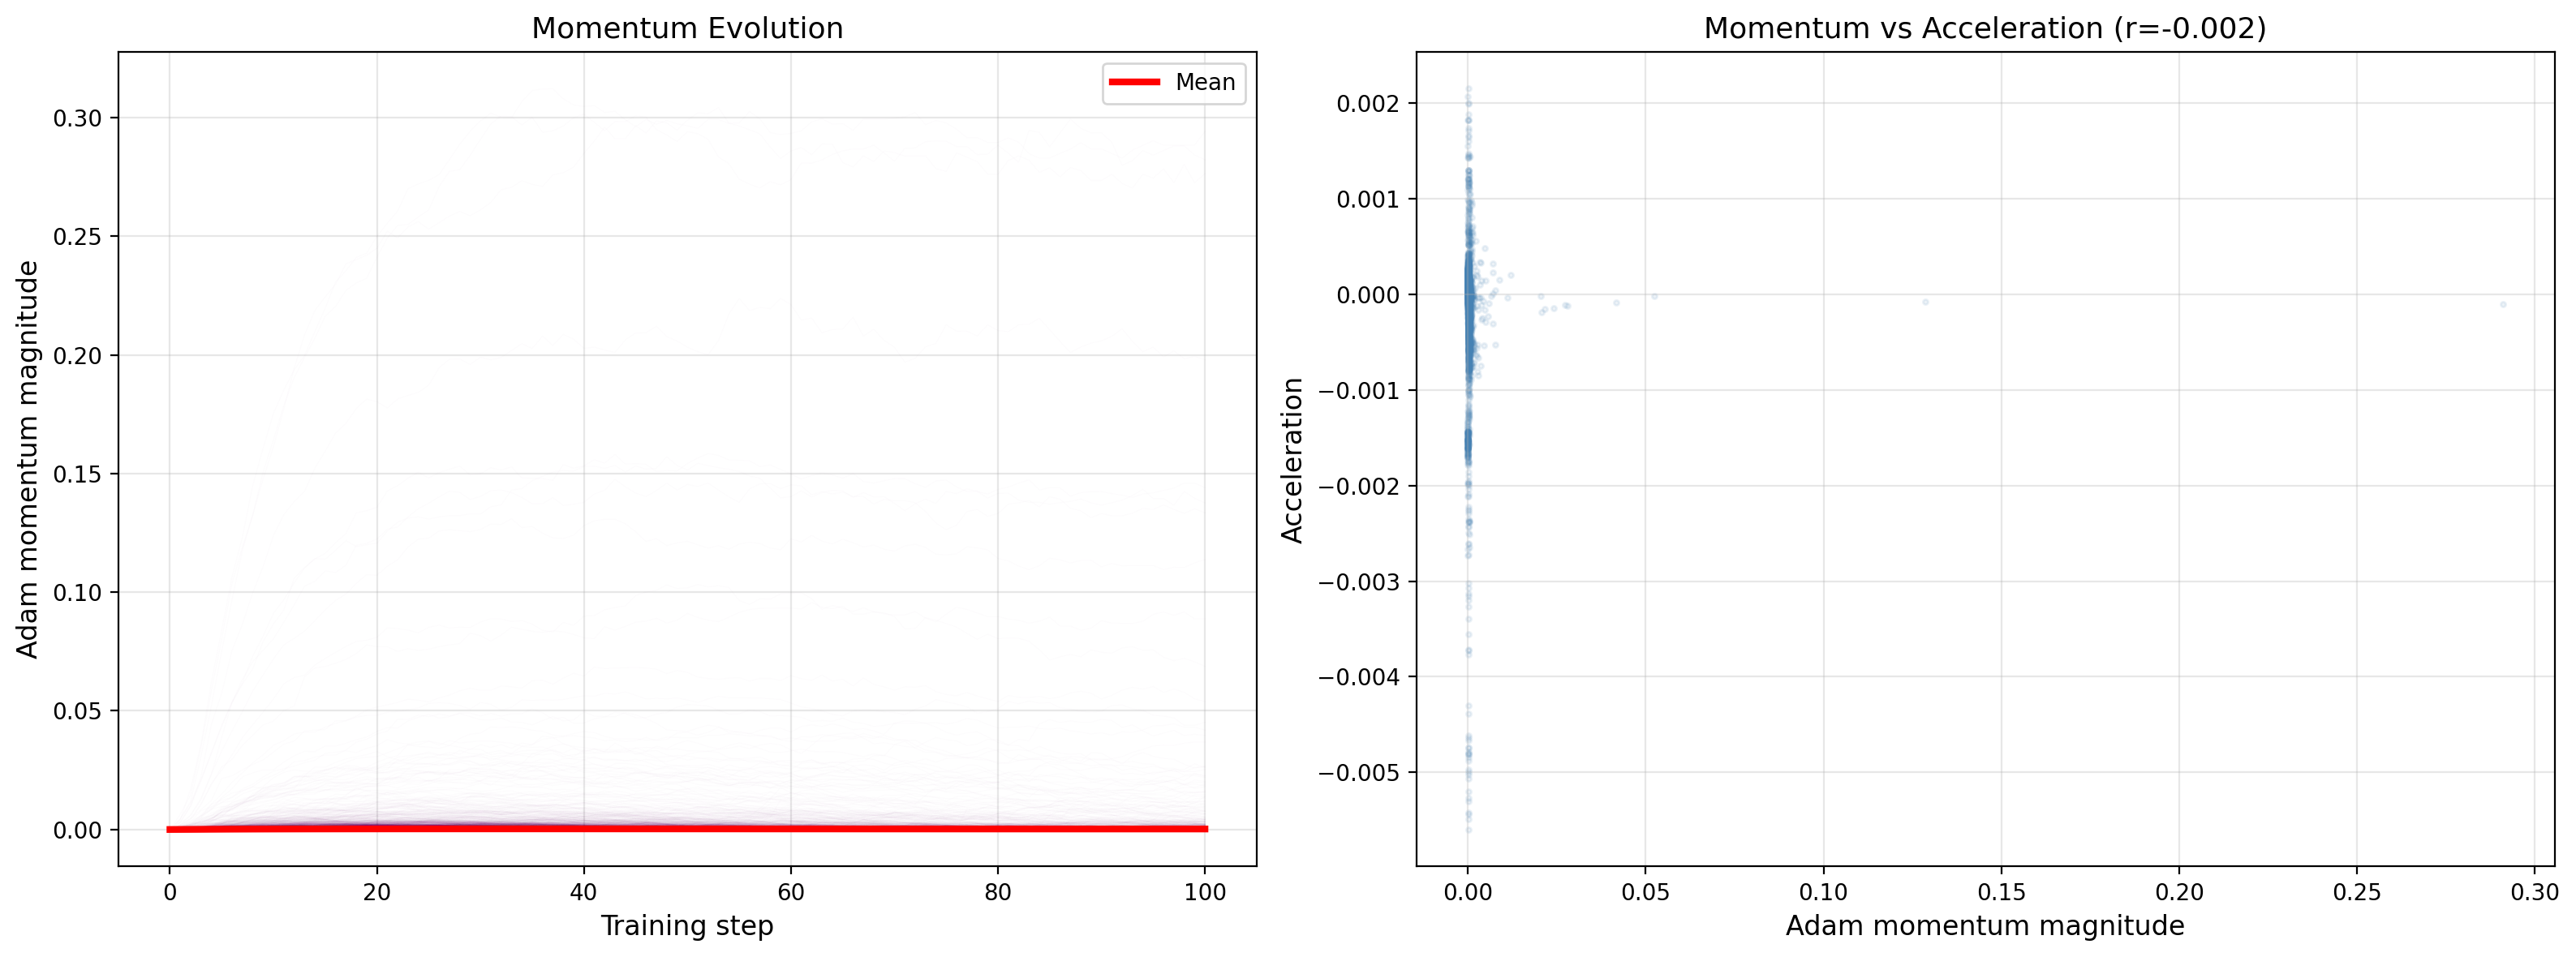

✓ Momentum correlation: r = -0.0021


In [20]:
if has_momentum:
    print("\nAnalyzing momentum vs acceleration correlation...\n")
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6), dpi=PLOT_DPI)
    
    # Left: Momentum magnitude over time (all tokens)
    ax = axes[0]
    mom_timesteps = np.arange(momentum_magnitudes.shape[0])
    
    for i in range(n_trained):
        ax.plot(mom_timesteps, momentum_magnitudes[:, i].numpy(), 
                color='purple', alpha=ALPHA, linewidth=0.5)
    
    mom_mean = momentum_magnitudes.mean(dim=1).numpy()
    ax.plot(mom_timesteps, mom_mean, color='red', linewidth=3, label='Mean', zorder=10)
    
    ax.set_xlabel('Training step', fontsize=12)
    ax.set_ylabel('Adam momentum magnitude', fontsize=12)
    ax.set_title('Momentum Evolution', fontsize=13)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Right: Scatter of momentum vs acceleration (aggregated over time)
    ax = axes[1]
    
    # Align timesteps (momentum has n_steps, acceleration has n_steps-2)
    # Use momentum at t+1 (when acceleration is computed)
    mom_aligned = momentum_magnitudes[1:-1]  # (n_steps-2, n_trained)
    
    # Flatten for scatter
    mom_flat = mom_aligned.flatten().numpy()
    accel_flat = accelerations.flatten().numpy()
    
    # Subsample for plotting (too many points)
    sample_size = min(10000, len(mom_flat))
    sample_idx = np.random.choice(len(mom_flat), sample_size, replace=False)
    
    ax.scatter(mom_flat[sample_idx], accel_flat[sample_idx], 
              alpha=0.1, s=5, c='steelblue')
    
    # Compute correlation
    corr = np.corrcoef(mom_flat, accel_flat)[0, 1]
    
    ax.set_xlabel('Adam momentum magnitude', fontsize=12)
    ax.set_ylabel('Acceleration', fontsize=12)
    ax.set_title(f'Momentum vs Acceleration (r={corr:.3f})', fontsize=13)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"✓ Momentum correlation: r = {corr:.4f}")
else:
    print("\nSkipping momentum analysis (data not available)")

## Summary

In [21]:
print(f"\n{'='*80}")
print(f"S-CURVE HYPOTHESIS ANALYSIS")
print(f"{'='*80}\n")

print(f"Dataset: {TRAINING_DATA_PATH}")
print(f"  Steps: {n_steps}")
print(f"  Trained tokens: {n_trained:,}")
print()

# Check for S-curve in mean acceleration
early_mean = accel_mean[:len(accel_mean)//3].mean()
mid_mean = accel_mean[len(accel_mean)//3:2*len(accel_mean)//3].mean()
late_mean = accel_mean[2*len(accel_mean)//3:].mean()

print(f"Mean acceleration by phase:")
print(f"  Early (steps 1-{len(accel_mean)//3}): {early_mean:.6e}")
print(f"  Mid (steps {len(accel_mean)//3}-{2*len(accel_mean)//3}): {mid_mean:.6e}")
print(f"  Late (steps {2*len(accel_mean)//3}-{len(accel_mean)}): {late_mean:.6e}")
print()

has_s_curve = (mid_mean > early_mean) and (mid_mean > late_mean)

if has_s_curve:
    print(f"✓ S-CURVE DETECTED in aggregate")
    print(f"  Mid acceleration is {mid_mean/early_mean:.2f}× early acceleration")
    print(f"  Mid acceleration is {mid_mean/late_mean:.2f}× late acceleration")
else:
    print(f"⚠️  No clear S-curve in aggregate mean")
    print(f"  Pattern may be present in individual tokens but not aggregate")

print()
print(f"Speed evolution:")
print(f"  Initial mean speed: {speed_mean[0]:.6e}")
print(f"  Peak mean speed: {speed_mean.max():.6e} (step {speed_mean.argmax()})")
print(f"  Final mean speed: {speed_mean[-1]:.6e}")

if has_momentum:
    print()
    print(f"Momentum correlation: r = {corr:.4f}")
    if abs(corr) > 0.5:
        print(f"  → {'Strong positive' if corr > 0 else 'Strong negative'} correlation")
        print(f"  → Supports rocket hypothesis (momentum ~ effective mass)")
    else:
        print(f"  → Weak correlation")
        print(f"  → Momentum may not be the dominant factor")

print()
print(f"Interpretation:")
if has_s_curve:
    print(f"  The aggregate shows clear S-curve pattern!")
    print(f"  This supports the rocket equation hypothesis:")
    print(f"    - Early: Low momentum → low acceleration")
    print(f"    - Mid: Momentum building → peak acceleration")
    print(f"    - Late: Gradients decay or saturation → declining acceleration")
else:
    print(f"  Individual tokens may still show S-curves even if aggregate doesn't")
    print(f"  Check the example token plots for clearer patterns")

print(f"\n{'='*80}")


S-CURVE HYPOTHESIS ANALYSIS

Dataset: ../tensors/Wordybird/1.12c_wordybird_1.safetensors
  Steps: 101
  Trained tokens: 30,590

Mean acceleration by phase:
  Early (steps 1-33): -1.428022e-04
  Mid (steps 33-66): -5.950034e-05
  Late (steps 66-99): -3.395242e-05

⚠️  No clear S-curve in aggregate mean
  Pattern may be present in individual tokens but not aggregate

Speed evolution:
  Initial mean speed: 7.800586e-03
  Peak mean speed: 7.800586e-03 (step 0)
  Final mean speed: 4.171513e-06

Momentum correlation: r = -0.0021
  → Weak correlation
  → Momentum may not be the dominant factor

Interpretation:
  Individual tokens may still show S-curves even if aggregate doesn't
  Check the example token plots for clearer patterns

